# Description

* Merging raw reads with PEAR

## Setting variables

In [7]:
seqdir = '/home/backup_files/raw_reads/fullcyc2.Barnett.2018/160713_FC2Unfrac/run2'
workdir = '/home/seq_data/fullCyc2/amplicon/515F-806R/final_dataset/library_QC/160713_FC2Unfrac'

library = '160713_FC2Unfrac'

readFile1 = 'read1.fq.gz'
readFile2 = 'read2.fq.gz'

# Init

In [8]:
import screed
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from mpld3 import enable_notebook
import screed
import pandas as pd
import os

In [9]:
%matplotlib inline  
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [10]:
%%R
library(ggplot2)
library(dplyr)

### Check that your sequence files and directories do exist and are named as above

In [11]:
if not os.path.isdir(seqdir):
    print ('Sequence directory Path Does NOT exist!!')
else:
    %cd $seqdir

/home/backup_files/raw_reads/fullcyc2.Barnett.2018/160713_FC2Unfrac/run2


In [12]:
!cd $seqdir; ls -thlc *fq.gz

-rw-rw-r-- 1 sam raw_reads 1.6G May 14 10:02 read2.fq.gz
-rw-rw-r-- 1 sam raw_reads 1.6G May 14 10:02 read1.fq.gz
-rw-rw-r-- 1 sam raw_reads  86M May 14 10:02 index_read2.fq.gz
-rw-rw-r-- 1 sam raw_reads  88M May 14 10:02 index_read1.fq.gz


In [13]:
if not os.path.isdir(workdir):
    os.makedirs(workdir)
%cd $workdir

/home/seq_data/fullCyc2/amplicon/515F-806R/final_dataset/library_QC/160713_FC2Unfrac


## Uncompress the fastq files

In [14]:
output1 = os.path.join(workdir, "forward.fastq")
readFile1 = os.path.join(seqdir, readFile1)

!cd $workdir; \
    pigz -k -d -p 20 -c $readFile1 > $output1

In [15]:
output2 = os.path.join(workdir, "reverse.fastq")
readFile2 = os.path.join(seqdir, readFile2)

!cd $workdir; \
    pigz -k -d -p 20 -c $readFile2 > $output2

# Merging


In [16]:
!cd $workdir; \
    pear -m 600 -j 20 \
    -f forward.fastq \
    -r reverse.fastq \
    -o pear_merged-$library

 ____  _____    _    ____ 
|  _ \| ____|  / \  |  _ \
| |_) |  _|   / _ \ | |_) |
|  __/| |___ / ___ \|  _ <
|_|   |_____/_/   \_\_| \_\

PEAR v0.9.10 [May 30, 2016]

Citation - PEAR: a fast and accurate Illumina Paired-End reAd mergeR
Zhang et al (2014) Bioinformatics 30(5): 614-620 | doi:10.1093/bioinformatics/btt593

Forward reads file.................: forward.fastq
Reverse reads file.................: reverse.fastq
PHRED..............................: 33
Using empirical frequencies........: YES
Statistical method.................: OES
Maximum assembly length............: 600
Minimum assembly length............: 50
p-value............................: 0.010000
Quality score threshold (trimming).: 0
Minimum read size after trimming...: 1
Maximal ratio of uncalled bases....: 1.000000
Minimum overlap....................: 10
Scoring method.....................: Scaled score
Threads............................: 20

Allocating memory..................: 200,000,000 bytes
Computing empiric

# Making a screed db of merged reads

In [17]:
pear_merged_file = 'pear_merged-' + library + '.assembled.fastq'

os.chdir(workdir)
screed.read_fastq_sequences(pear_merged_file)

<ScreedDB, 'pear_merged-160713_FC2Unfrac.assembled.fastq_screed'>

In [18]:
pear_merged_file += '_screed'
fqdb = screed.ScreedDB(pear_merged_file)

In [19]:
pear_merged_file

'pear_merged-160713_FC2Unfrac.assembled.fastq_screed'

In [20]:
lengths = []
for read in fqdb.itervalues():
    lengths.append((len(read["sequence"])))

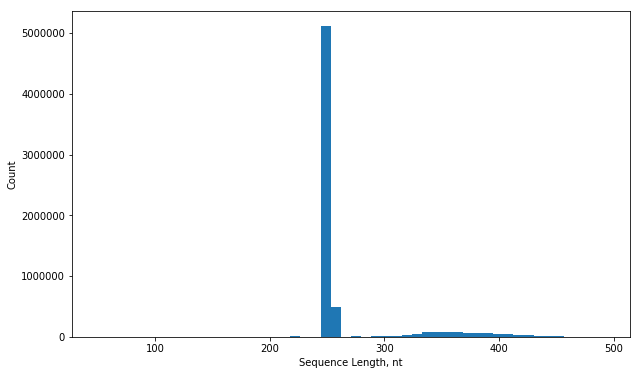

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111)
h = ax.hist(np.array(lengths), bins=50)
xl = ax.set_xlabel("Sequence Length, nt")
yl = ax.set_ylabel("Count")
fig.set_size_inches((10,6))

In [22]:
print ('Number of reads: {}'.format(len(lengths)))

Number of reads: 6476542


## Quality stats on merged reads


In [27]:
def qualStats(sourceDir, fileName):
    outFile = fileName + '_qualStats'
    !cd $sourceDir; \
        fastx_quality_stats -i $fileName -o $outFile -Q 33
    return outFile
    
qualStatsRes = qualStats(workdir, 'pear_merged-' + library + '.assembled.fastq')

In [28]:
%%R -i workdir -i qualStatsRes

setwd(workdir)

# reading in qual-stats files    
tbl.r12 = read.delim(qualStatsRes, sep='\t')
rownames(tbl.r12) = 1:nrow(tbl.r12)

/home/sam/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: `geom_smooth()` using method = 'loess'

  warnings.warn(x, RRuntimeWarning)


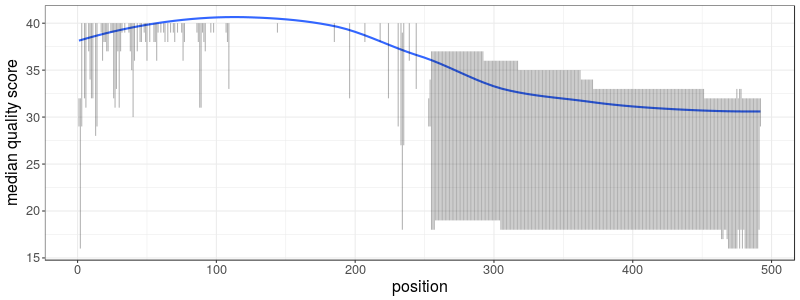

In [29]:
%%R -w 800 -h 300
# smooth curve on median qual values
ggplot(tbl.r12, aes(x=column, y=med, ymin=Q1, ymax=Q3)) +
    geom_smooth(se=FALSE, method='auto') +
    geom_linerange(alpha=0.3) +
    labs(x='position', y='median quality score') +
    theme_bw() +
    theme( 
        text = element_text(size=16) 
        )

## Clean up
Remove temporary files made during this process. These are really big files that you no longer need. If you are worried about having to re-do something then you can skip this step and clean up manually at the very end.